In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout, AveragePooling1D, LSTM, MaxPooling1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
import os

In [ ]:
def calculate_future_price_optimized(df, minutes_ahead=5):
    df['time'] = pd.to_datetime(df['time'])
    temp_df = df.copy()
    temp_df.set_index('time', inplace=True)

    # resampling operation
    resampled_df = temp_df.resample(f'{minutes_ahead}min').agg({'mid_price': 'mean'})
    resampled_df['future_mid_price'] = resampled_df['mid_price'].shift(-minutes_ahead)
    resampled_df.reset_index(inplace=True)
    final_df = pd.merge_asof(df.sort_values('time'), resampled_df[['time', 'future_mid_price']].sort_values('time'),
                             on='time', direction='forward')

    return final_df

In [ ]:
def plot_training_history(trainHistory, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(trainHistory.history['accuracy'])
    plt.plot(trainHistory.history['val_accuracy'])
    plt.title(f'Model Accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(trainHistory.history['loss'])
    plt.plot(trainHistory.history['val_loss'])
    plt.title(f'Model Loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [ ]:
def add_direction_based_on_future_price(df):

    conditions = [
        (df['future_mid_price'] > df['mid_price']),  # Condition for 1
        (df['future_mid_price'] < df['mid_price']),  # Condition for 0
    ]
    choices = [1, 0]  # Corresponding choices for conditions

    # Use np.select to apply conditions and choices, with tqdm to show progress
    df['direction'] = np.select(conditions, choices, default=0)  # default is 0 if neither condition is met

    df.dropna(inplace=True)
    return df

In [ ]:
def calculate_correlation_matrix(df):
    correlation_matrix = df.corr()
    return correlation_matrix

In [ ]:
def plot_correlation_heatmap(correlation_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', linewidths=.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()


In [ ]:
def identify_highly_correlated_features(correlation_matrix, threshold=0.9):
    highly_correlated_pairs = {}
    for col in correlation_matrix.columns:
        for row in correlation_matrix.index:
            if abs(correlation_matrix[col][row]) > threshold and col != row:
                highly_correlated_pairs[(col, row)] = correlation_matrix[col][row]
    return highly_correlated_pairs

In [ ]:
def filter_redundant_features(df, highly_correlated_pairs):
    # Remove the second feature in the tuple
    features_to_remove = {pair[1] for pair in highly_correlated_pairs}
    filtered_df = df.drop(columns=features_to_remove)
    return filtered_df

In [ ]:
def compute_order_book_features(df, depth=5):
    # Calculate mid-price and add it to the DataFrame before other calculations
    df['mid_price'] = (df['bidPrice_1'] + df['askPrice_1']) / 2

    # Initialize empty DataFrame for features
    features = pd.DataFrame(index=df.index)
    features['time'] = df['time']

    # Use the newly added 'mid_price' column for further feature calculations
    features['mid_price'] = df['mid_price']
    features['spread'] = df['askPrice_1'] - df['bidPrice_1']  # Calculate book imbalance for top 'depth' levels
    total_bid_volume = df[[f'bidSize_{i}' for i in range(1, depth + 1)]].sum(axis=1)
    total_ask_volume = df[[f'askSize_{i}' for i in range(1, depth + 1)]].sum(axis=1)
    features['book_imbalance'] = (total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume)

    # Calculate VWAP distance from mid-price for bids and asks
    bid_vwap = sum(df[f'bidPrice_{i}'] * df[f'bidSize_{i}'] for i in range(1, depth + 1)) / total_bid_volume
    ask_vwap = sum(df[f'askPrice_{i}'] * df[f'askSize_{i}'] for i in range(1, depth + 1)) / total_ask_volume
    features['bid_vwap_distance'] = features['mid_price'] - bid_vwap
    features['ask_vwap_distance'] = ask_vwap - features['mid_price']

    # Price and volume trends over recent ticks
    for window in [1, 5, 10]:  # Example windows: last 1, 5, and 10 ticks
        df_rolled = df[['bidPrice_1', 'askPrice_1', 'bidSize_1', 'askSize_1']].rolling(window=window)
        features[f'bidPrice_trend_{window}'] = df_rolled['bidPrice_1'].mean()
        features[f'askPrice_trend_{window}'] = df_rolled['askPrice_1'].mean()
        features[f'bidSize_trend_{window}'] = df_rolled['bidSize_1'].mean()
        features[f'askSize_trend_{window}'] = df_rolled['askSize_1'].mean()

    # Historical volatility (using mid-price)
    features['historical_volatility'] = features['mid_price'].diff().rolling(window=10).std()

    # Time of day and market session
    features['time_of_day'] = df['time'].dt.hour + df['time'].dt.minute / 60 + df['time'].dt.second / 3600
    features['day_of_week'] = df['time'].dt.dayofweek

    # Calculate mid-price movement (lagged to avoid look-ahead bias)
    features['mid_price_movement'] = features['mid_price'].diff().shift(-1)

    # Calculate order flow momentum (difference in bid and ask updates, lagged)
    features['order_flow_momentum'] = (df['bidSize_1'] - df['askSize_1']).diff().shift(-1)

    # Moving Averages
    for window in [5, 10, 20]:  # Example windows
        features[f'sma_{window}'] = features['mid_price'].rolling(window=window).mean()
        features[f'ema_{window}'] = features['mid_price'].ewm(span=window, adjust=False).mean()

    # Drop NaN values created by rolling functions
    features = features.dropna()

    return features

In [ ]:
def handle_zeros_in_data(df):
    # Function to replace zeros with the nearest non-zero values in the same column
    for col in df.columns:
        if 'Price' in col or 'Size' in col:  # Only apply to Price and Size columns
            # Replace 0 with NaN to use fillna with method='ffill'/'bfill'
            df[col] = df[col].replace(0, np.nan)

            # Forward fill to replace NaN with the nearest non-zero value ahead in the column
            df[col] = df[col].ffill()

            # Backward fill to replace any remaining NaNs with the nearest non-zero value behind in the column
            df[col] = df[col].bfill()

            # If there are still any NaNs left, replace them with 0 (should only happen if a column is all zeros)
            df[col] = df[col].fillna(0)

    return df

In [ ]:
class ModelTraining:
    def __init__(self, database_path):
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_test = None
        self.y_train = None
        self.model = None
        self.parameters = []
        if os.path.splitext(database_path)[1] == ".csv":
            self.df = pd.read_csv(database_path)
        elif os.path.splitext(database_path)[1] == ".db":
            engine = create_engine(f"sqlite:///{database_path}")
            self.df = pd.read_sql("SELECT * from ES_market_depth", engine)
        print("Raw data collected for level 2 depth from interactive brokers:")
        print(self.df.head())
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
        self.scaler = StandardScaler()
        self.logdir = "logs/fit/" + "agentLearning" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=self.logdir)
        self.optimizer = Nadam(learning_rate=0.01)
        self.models = {}

    def preprocess_data(self, minutes_ahead=5, division_factor=4):
        # Ensure 'time' is in datetime format
        self.df['time'] = pd.to_datetime(self.df['time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
        self.df.loc[self.df['time'].isna(), 'time'] = pd.to_datetime(self.df.loc[self.df['time'].isna(), 'time'],
                                                                     format='%Y-%m-%d %H:%M:%S', errors='coerce')
        self.df.dropna(subset=['time'], inplace=True)

        # Handle zeros in bid and ask prices and volumes
        self.df = handle_zeros_in_data(self.df)

        # Compute custom features based on order book data
        features_df = compute_order_book_features(self.df)

        self.df.sort_values(by='time', inplace=True)

        self.df = calculate_future_price_optimized(self.df, minutes_ahead)

        # Make sure both DataFrames are sorted by time
        self.df.sort_values(by='time', inplace=True)
        features_df.sort_values(by='time', inplace=True)

        # Rename 'mid_price' in features_df to 'price_y' before merging
        features_df.rename(columns={'mid_price': 'price_y'}, inplace=True)

        # Calculate correlation matrix
        correlation_matrix = features_df.corr()

        # Plot heatmap
        plot_correlation_heatmap(correlation_matrix)

        # Identify highly correlated features
        highly_correlated_pairs = identify_highly_correlated_features(correlation_matrix)

        # Filter redundant features
        features_df_filtered = filter_redundant_features(features_df, highly_correlated_pairs)

        # Use merge_asof to merge the features back into the main DataFrame based on the 'time' column
        merged_df = pd.merge_asof(self.df.sort_values('time'), features_df_filtered.sort_values('time'), on='time',
                                  direction='nearest')

        # Use np.select to apply conditions and choices
        merged_df = add_direction_based_on_future_price(merged_df)
        merged_df.dropna(inplace=True)

        csv_filename = "preprocessed_data.csv"  # Define the name of CSV file
        merged_df.to_csv(csv_filename, index=False)  # Save the DataFrame to a CSV file without the index
        print(f"Preprocessed data saved to {csv_filename}")
        merged_df = merged_df.drop("future_mid_price", axis=1)
        self.df = self.df.drop("future_mid_price", axis=1)
        half_index = len(merged_df) // division_factor
        merged_df = merged_df.iloc[:half_index]

        self.merged_df = merged_df

        print("Final dataFrame used for training and validation is")
        print(merged_df.head())

        # Select only the numerical columns (excluding 'time')
        numerical_columns = [col for col in merged_df.columns if col not in ['time', 'direction']]

        self.parameters = merged_df[numerical_columns].columns

        self.X = merged_df[numerical_columns].values
        self.y = merged_df['direction'].values

        # Splitting the dataset into training and testing sets, normalizing the feature set
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3,
                                                                                random_state=42, shuffle=False)
        self.scaler.fit(self.X_train)
        self.X_train = self.scaler.transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        # Adjust y values for binary classification: map -1 to 0, keep 1 as is
        self.y_train = np.where(self.y_train == -1, 0, self.y_train)
        self.y_test = np.where(self.y_test == -1, 0, self.y_test)

        unique, counts = np.unique(self.y_train, return_counts=True)
        count_dict = dict(zip(unique, counts))

        # Ensure that both 0 and 1 are present in the array
        if 0 in count_dict and 1 in count_dict:
            ratio_of_1s = count_dict[1] / (count_dict[0] + count_dict[1])
            ratio_of_0s = count_dict[0] / (count_dict[0] + count_dict[1])
            print(f"Ratio of 1s in training: {ratio_of_1s}")
            print(f"Ratio of 0s in training: {ratio_of_0s}")
        else:
            print("One of the classes is missing in the training data.")


    def Dense_model(self):
        """
        Build and train a dense neural network model for binary classification.

        The model architecture includes densely connected layers with regularization
        and dropout to prevent overfitting. The output layer uses a sigmoid activation
        function for binary classification.

        Returns:
            trainHistory: The history object containing training information.
            val_accuracy: The validation accuracy from the last epoch.
            val_loss: The validation loss from the last epoch.
        """
        # Define the input layer based on the shape of the training data
        input_layer = Input(shape=(self.X_train.shape[1],))

        # Add dense layers with increasing numbers of nodes and regularization
        x = Dense(self.X_train.shape[1] , activation='relu', kernel_regularizer='l2')(input_layer)
        x = Dropout(0.3)(x)  # Apply dropout for regularization

        # Another dense layer with regularization
        x = Dense(21, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(0.3)(x)  # Apply dropout for regularization

        # Output layer with a sigmoid activation function for binary classification
        output_layer = Dense(1, activation='sigmoid', kernel_regularizer='l2')(x)

        # Create the model object with input and output layers
        model = Model(inputs=input_layer, outputs=output_layer)

        # Print model's layers and trainable parameters
        print(model.summary())

        # Compile the model with binary crossentropy loss and Nadam optimizer
        model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ])

        # Callbacks for learning rate adjustment and early stopping
        lr_adjust = ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
        early_stop = EarlyStopping(
            monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
        callbacks = [early_stop, self.tensorboard_callback, lr_adjust]

        # Train the model while monitoring the validation set
        trainHistory = model.fit(
            self.X_train, self.y_train, epochs=150, batch_size=32000,
            validation_data=(self.X_test, self.y_test), callbacks=callbacks)

        # Store the trained model in the class instance
        self.model_dense = model

        # Return the training history along with the final epoch's validation metrics
        return trainHistory, trainHistory.history['val_accuracy'][-1], trainHistory.history['val_loss'][-1]

    def Transformer_model(self):
        input_shape = (self.X_train.shape[1],)  # Ensure this matches your feature count

        inputs = Input(shape=input_shape)
        x = inputs

        # Transformer block
        for _ in range(2):  # Number of transformer blocks
            # Multi-head self-attention
            attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
            attn_output = Dropout(0.1)(attn_output)
            x = LayerNormalization(epsilon=1e-6)(x + attn_output)

            # Feed-forward network
            # Ensure the output of Dense matches x's last dimension
            ffn_output = Dense(input_shape[0], activation="relu")(x)  # Match the dimension
            ffn_output = Dropout(0.1)(ffn_output)
            x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

        # Output layer for binary classification
        x = Dense(64, activation="relu")(x)
        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        print(model.summary())

        train_history = model.fit(
            self.X_train, self.y_train, epochs=100, batch_size=32,
            validation_data=(self.X_test, self.y_test)
        )

        self.model_transformer = model

        # Return the training history along with the final epoch's validation metrics
        return trainHistory, trainHistory.history['val_accuracy'][-1], trainHistory.history['val_loss'][-1]



    def LSTMCNN_model(self):
        """
        Build and train a hybrid LSTM-CNN model for binary classification.

        The model architecture includes LSTM layers for temporal pattern recognition
        combined with Conv1D layers for feature extraction from sequences.
        Dropout is used for regularization and BatchNormalization for stabilizing learning.

        Returns:
            trainHistory: The history object containing training information.
            val_accuracy: The validation accuracy from the last epoch.
            val_loss: The validation loss from the last epoch.
        """

        # Reshape input data to include a channel dimension for LSTM layers
        X_train_reshaped = np.expand_dims(self.X_train, axis=-1)
        X_test_reshaped = np.expand_dims(self.X_test, axis=-1)

        # Define the input layer with the shape of the reshaped training data
        input_layer = Input(shape=(X_train_reshaped.shape[1], 1))

        # Define an LSTM layer with L1 regularization to help prevent overfitting
        x = LSTM(512, return_sequences=True, kernel_regularizer='l2')(input_layer)
        x = Dropout(0.3)(x)  # Apply dropout for regularization

        # Add a Conv1D layer for feature extraction from sequences
        x = Conv1D(filters=256, kernel_size=24, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(0.3)(x)  # Apply dropout for regularization
        x = AveragePooling1D(pool_size=2)(x)  # Reduce dimensionality and prevent overfitting
        x = BatchNormalization()(x)  # Normalize the activations from the previous layer

        x = Flatten()(x)  # Flatten the 3D output to 1D for input to the dense layer

        # Add a dense layer with L1 regularization to learn complex patterns
        x = Dense(32, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(0.3)(x)  # Apply dropout for regularization

        # Output layer with a sigmoid activation for binary classification
        output = Dense(1, activation='sigmoid')(x)

        # Create the model object with input and output layers
        model = Model(inputs=input_layer, outputs=output)

        # Print model's layers and trainable parameters
        print(model.summary())

        # Compile the model with binary crossentropy loss and the NAdam optimizer
        model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ])

        # Define callbacks for dynamic learning rate adjustment and early stopping
        lr_adjust = ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
        early_stop = EarlyStopping(
            monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
        callbacks = [early_stop, self.tensorboard_callback, lr_adjust]

        # Train the model and save the history
        trainHistory = model.fit(
            X_train_reshaped, self.y_train, epochs=150, batch_size=1600,
            validation_data=(X_test_reshaped, self.y_test), callbacks=callbacks)
        self.model_lstmcnn = model

        # Return the training history and the last epoch's validation accuracy and loss
        return trainHistory, trainHistory.history['val_accuracy'][-1], trainHistory.history['val_loss'][-1]


    def check_and_convert_target_variable(self):
        # Check if the target variable contains more than two unique values
        if len(np.unique(self.y_train)) > 2:
            # Convert target variable to binary format using LabelEncoder for training data
            label_encoder = LabelEncoder()
            self.y_train = label_encoder.fit_transform(self.y_train)

        if len(np.unique(self.y_test)) > 2:
            # Convert target variable to binary format using LabelEncoder for test data
            label_encoder = LabelEncoder()
            self.y_test = label_encoder.transform(self.y_test)


    def treeDecision_model(self):
        """
        Build and train a Decision Tree model with pruning for binary classification.

        Uses cost complexity pruning to reduce tree complexity and prevent overfitting.

        Returns:
            model: The trained Decision Tree model.
        """
        # Check and convert the target variable if necessary
        self.check_and_convert_target_variable()

        # Initialize the DecisionTreeClassifier with cost complexity pruning
        ccp_alpha = 0.01  # Set an appropriate alpha value for pruning
        self.model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)

        # Fit the model on the entire training dataset
        self.model.fit(self.X_train, self.y_train)

        return self.model

Raw data collected for level 2 depth from interactive brokers:
   bidSize_1  bidPrice_1  askPrice_1  askSize_1  bidSize_2  bidPrice_2  \
0        5.0      5187.0        0.00        0.0        0.0        0.00   
1        5.0      5187.0     5187.25       18.0       29.0     5186.75   
2        5.0      5187.0     5187.25       18.0       29.0     5186.75   
3        6.0      5187.0     5187.25       18.0       29.0     5186.75   
4        6.0      5187.0     5187.25       16.0       28.0     5186.75   

   askPrice_2  askSize_2  bidSize_3  bidPrice_3  ...  bidPrice_9  askPrice_9  \
0         0.0        0.0        0.0         0.0  ...         0.0        0.00   
1      5187.5       23.0       51.0      5186.5  ...      5185.0     5189.25   
2      5187.5       26.0       51.0      5186.5  ...      5185.0     5189.25   
3      5187.5       26.0       51.0      5186.5  ...      5185.0     5189.25   
4      5187.5       26.0       51.0      5186.5  ...      5185.0     5189.25   

   askSize_

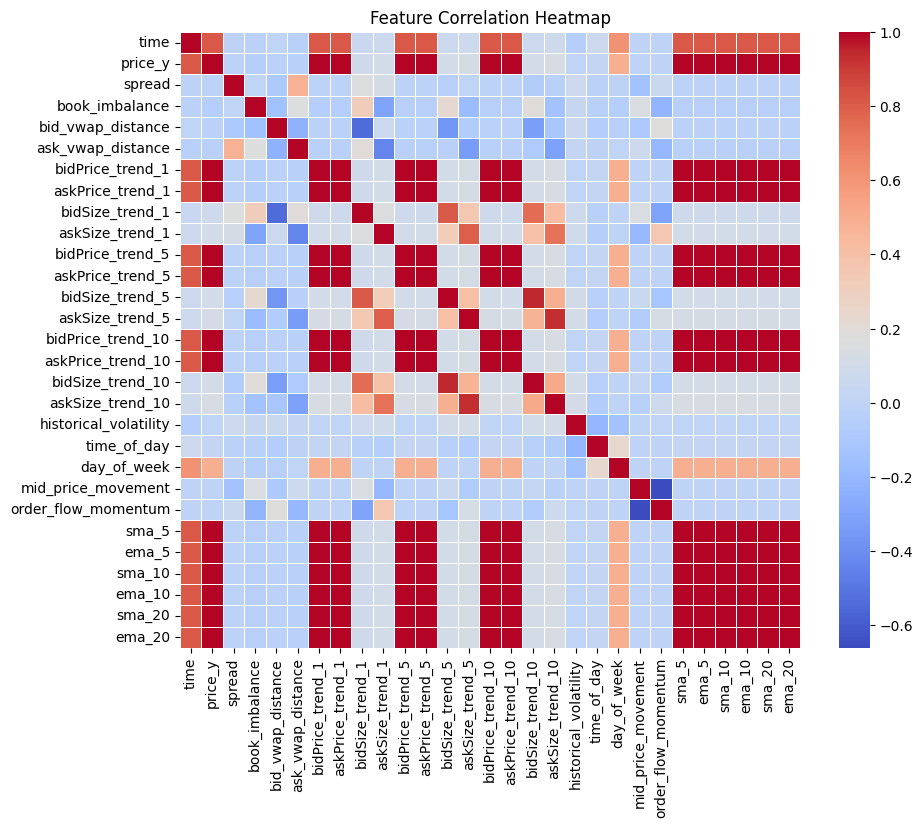

Preprocessed data saved to preprocessed_data.csv
Final dataFrame used for training and validation is
   bidSize_1  bidPrice_1  askPrice_1  askSize_1  bidSize_2  bidPrice_2  \
0        5.0      5187.0     5187.25       18.0       29.0     5186.75   
1        5.0      5187.0     5187.25       18.0       29.0     5186.75   
2        5.0      5187.0     5187.25       18.0       29.0     5186.75   
3        6.0      5187.0     5187.25       18.0       29.0     5186.75   
4        6.0      5187.0     5187.25       16.0       28.0     5186.75   

   askPrice_2  askSize_2  bidSize_3  bidPrice_3  ...  bid_vwap_distance  \
0      5187.5       23.0       51.0      5186.5  ...           0.684932   
1      5187.5       23.0       51.0      5186.5  ...           0.684932   
2      5187.5       26.0       51.0      5186.5  ...           0.684932   
3      5187.5       26.0       51.0      5186.5  ...           0.684932   
4      5187.5       26.0       51.0      5186.5  ...           0.684932   

   

In [ ]:
"""
mt = model training with 1/4th of the training data

mt2 = model validation with different data
"""

mt = ModelTraining(database_path='/content/drive/MyDrive/database/ES_ticks.db')
mt.preprocess_data(division_factor = 4) #Using only 1/4th of the data, to avoid extreme computational resources

In [ ]:
# mt2 uses a different data to measure model accuracy
mt2 = ModelTraining(database_path='/content/drive/MyDrive/database/ES_ticksTest.db')
mt2.preprocess_data(division_factor=1) #Using complete data

NameError: name 'ModelTraining' is not defined

In [ ]:
# train decision tree
decision_tree_model = mt.treeDecision_model()

In [ ]:
# Use cross-validation to evaluate model performance
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(decision_tree_model, mt.X_train, mt.y_train, cv=kfold, scoring='accuracy')
print(f'Decision Tree Cross-Validation Accuracy: {cv_results.mean():.4f} (+/- {cv_results.std():.4f})')


Decision Tree Cross-Validation Accuracy: 0.9263 (+/- 0.0072)


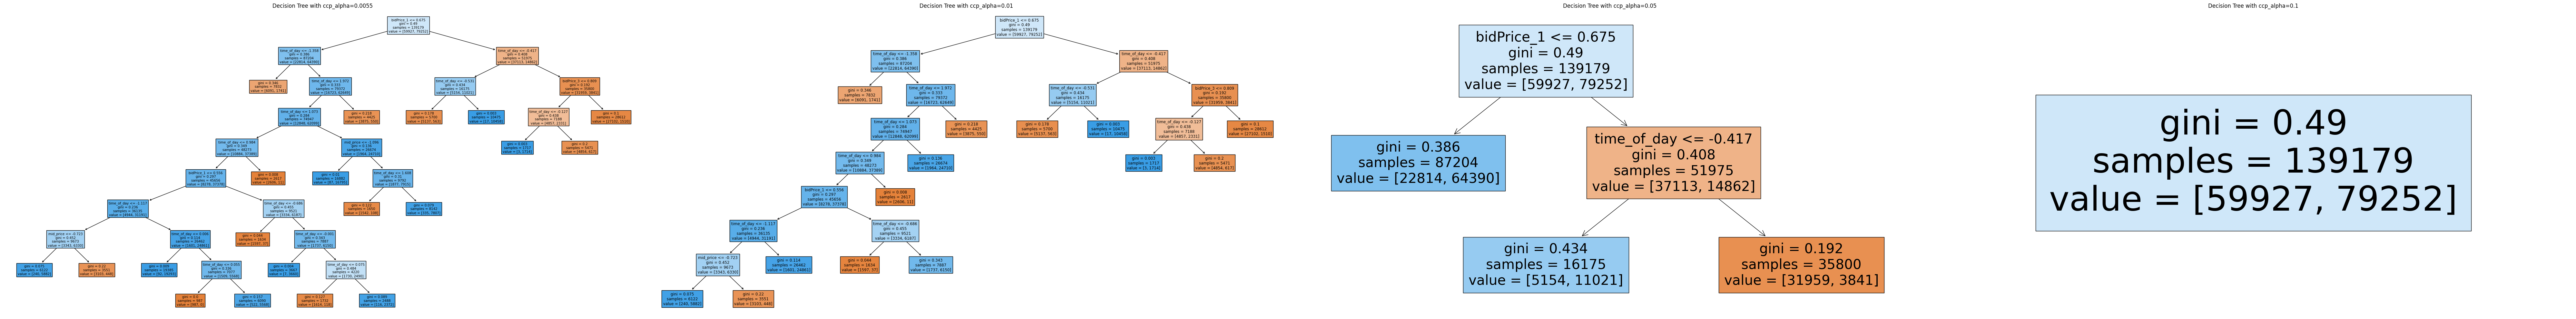

In [ ]:
ccp_alphas = [0.0055, 0.01, 0.05, 0.1]  # Example values
models = []
for alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    dt.fit(mt.X_train, mt.y_train)
    models.append(dt)

# Plot each tree with increasing ccp_alpha values
fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20 * len(models), 10))
for i, (model, ax) in enumerate(zip(models, axes.flatten())):
    plot_tree(model, filled=True, feature_names=mt.parameters, proportion=False, ax=ax)
    ax.set_title(f"Decision Tree with ccp_alpha={ccp_alphas[i]}")
plt.tight_layout()
plt.show()

Classification Report for ccp_alpha=0.0055:

              precision    recall  f1-score   support

           0       0.66      0.63      0.64     34106
           1       0.53      0.56      0.55     25543

    accuracy                           0.60     59649
   macro avg       0.59      0.59      0.59     59649
weighted avg       0.60      0.60      0.60     59649



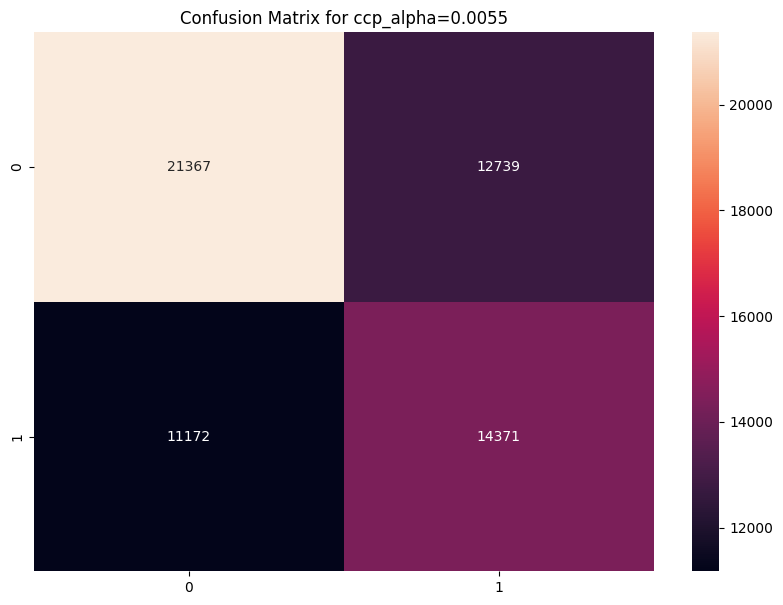

Accuracy for ccp_alpha=0.0055: 0.5991, Log Loss: 1.0760

Classification Report for ccp_alpha=0.01:

              precision    recall  f1-score   support

           0       0.73      0.35      0.47     34106
           1       0.49      0.83      0.61     25543

    accuracy                           0.55     59649
   macro avg       0.61      0.59      0.54     59649
weighted avg       0.63      0.55      0.53     59649



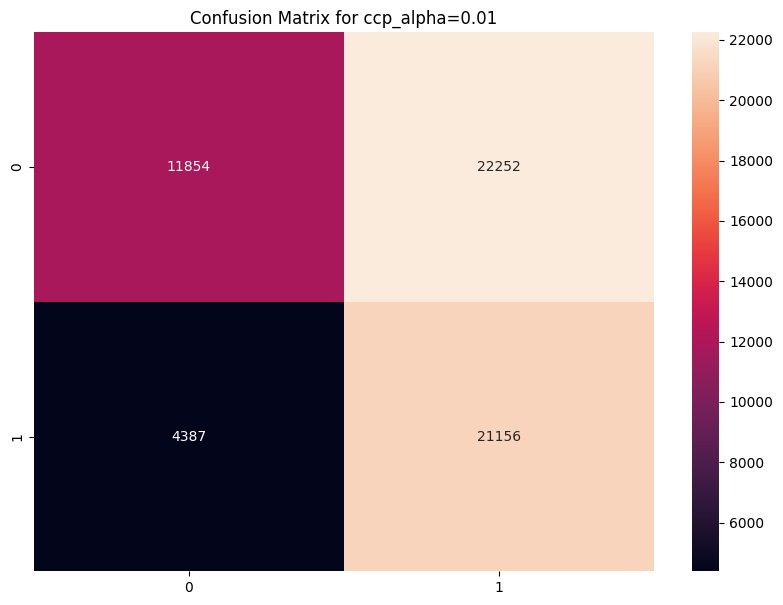

Accuracy for ccp_alpha=0.01: 0.5534, Log Loss: 1.1529

Classification Report for ccp_alpha=0.05:

              precision    recall  f1-score   support

           0       0.99      0.13      0.22     34106
           1       0.46      1.00      0.63     25543

    accuracy                           0.50     59649
   macro avg       0.73      0.56      0.43     59649
weighted avg       0.77      0.50      0.40     59649



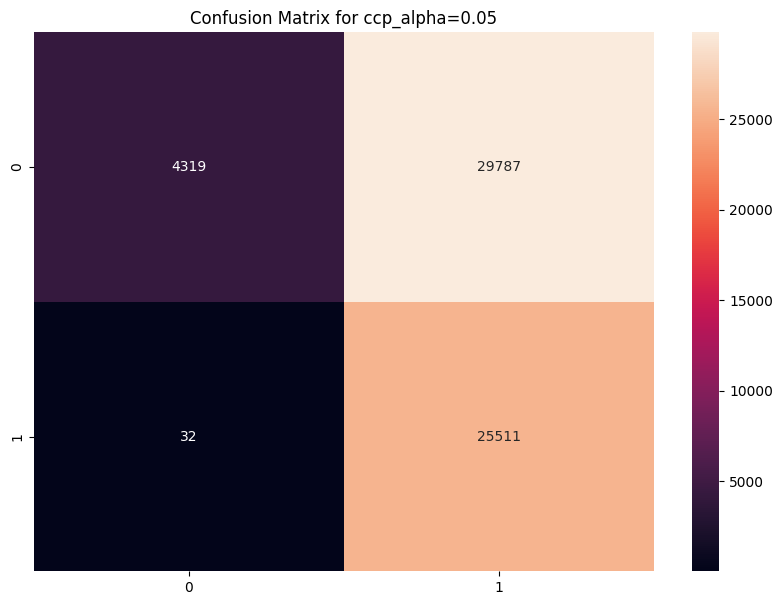

Accuracy for ccp_alpha=0.05: 0.5001, Log Loss: 0.8087

Classification Report for ccp_alpha=0.1:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     34106
           1       0.43      1.00      0.60     25543

    accuracy                           0.43     59649
   macro avg       0.71      0.50      0.30     59649
weighted avg       0.76      0.43      0.26     59649



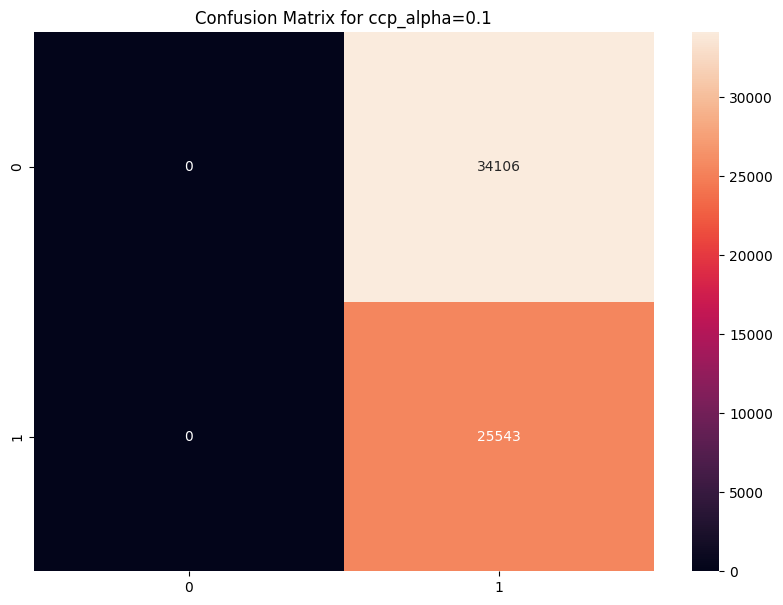

Accuracy for ccp_alpha=0.1: 0.4282, Log Loss: 0.7229



In [ ]:
# Evaluate each model
for i, model in enumerate(models):
    # Predict classes and probabilities for the test set
    y_pred = model.predict(mt.X_test)
    y_pred_proba = model.predict_proba(mt.X_test)

    # Print classification report
    print(f"Classification Report for ccp_alpha={ccp_alphas[i]}:\n")
    print(classification_report(mt.y_test, y_pred, zero_division=1))

    # Calculate and display confusion matrix
    cm = confusion_matrix(mt.y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix for ccp_alpha={ccp_alphas[i]}")
    plt.show()

    # Calculate accuracy and log loss
    accuracy = accuracy_score(mt.y_test, y_pred)
    loss = log_loss(mt.y_test, y_pred_proba)
    print(f"Accuracy for ccp_alpha={ccp_alphas[i]}: {accuracy:.4f}, Log Loss: {loss:.4f}\n")

In [ ]:
# According to results above we found the accuracy for ccp_alpha=0.0055 was the highest, therefore we will use that model for predictions
best_dt_model = models[0]

In [ ]:
# Choose a threshold
threshold = 0.5

# Apply model to the second dataframe to predict
predictions_dt_mt2 = best_dt_model.predict(mt2.X_test)

# Apply thresholding to convert probabilities to binary predictions
binary_predictions_dt_mt2 = (predictions_dt_mt2 > threshold).astype(int)

# Now you can use classification_report on binary predictions
print(classification_report(mt2.y_test, binary_predictions_dt_mt2))

              precision    recall  f1-score   support

           0       0.50      0.99      0.67     27251
           1       0.97      0.22      0.35     34273

    accuracy                           0.56     61524
   macro avg       0.73      0.60      0.51     61524
weighted avg       0.76      0.56      0.49     61524



In [ ]:
confusion_matrix(mt2.y_test,binary_predictions_dt_mt2)

array([[26990,   261],
       [26867,  7406]])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 54)]              0         
                                                                 
 dense (Dense)               (None, 54)                2970      
                                                                 
 dropout (Dropout)           (None, 54)                0         
                                                                 
 dense_1 (Dense)             (None, 21)                1155      
                                                                 
 dropout_1 (Dropout)         (None, 21)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 22        
                                                                 
Total params: 4147 (16.20 KB)
Trainable params: 4147 (16.20 K

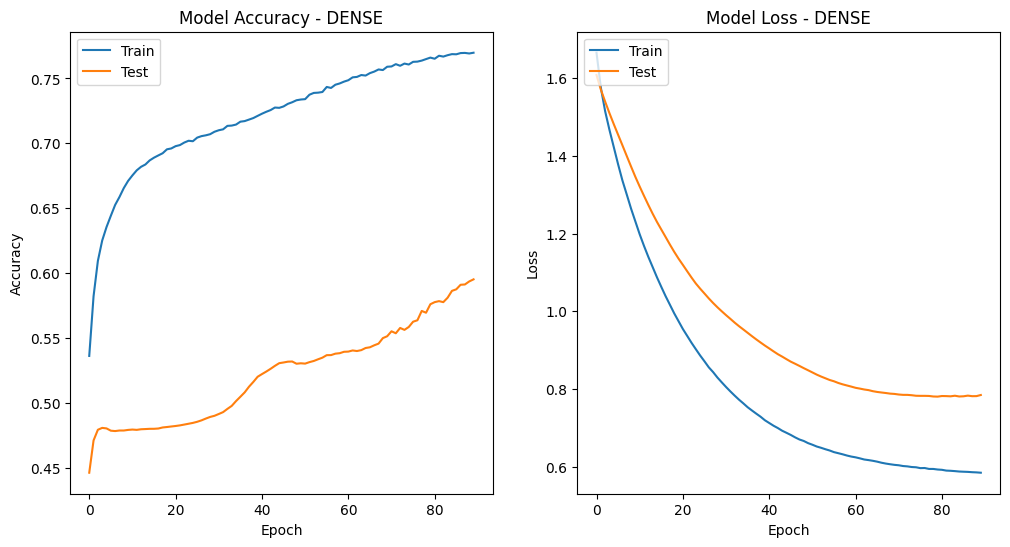

0.5952656269073486 0.7846876382827759


In [ ]:
  # Train the Dense model and get its history
trainHistory, accuracy, loss = mt.Dense_model()
#
# # Plot the training history
plot_training_history(trainHistory, "DENSE")

print(accuracy, loss)

In [ ]:
losses = pd.DataFrame(mt.model_dense.history.history)
losses.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,lr
0,1.664920,0.536288,0.579555,0.676223,1.607572,0.446328,0.423410,0.809772,0.001
1,1.575182,0.582272,0.618723,0.694178,1.570259,0.471190,0.436690,0.810124,0.001
2,1.514323,0.609488,0.648750,0.685169,1.539134,0.479421,0.441282,0.810437,0.001
3,1.466338,0.625166,0.666172,0.684992,1.509352,0.480863,0.442351,0.814548,0.001
4,1.422161,0.635534,0.675653,0.692260,1.481107,0.480461,0.442710,0.823944,0.001


<Axes: >

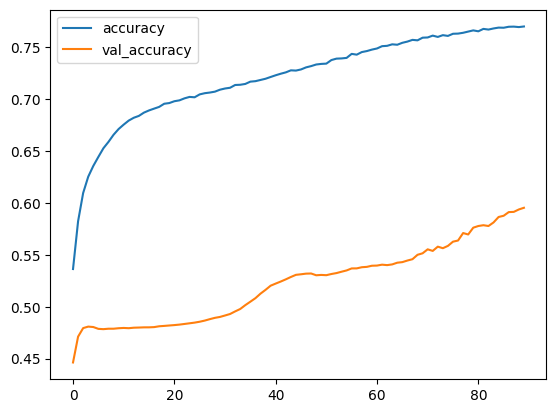

In [ ]:
losses[['accuracy','val_accuracy']].plot()

In [ ]:
print(mt.model_dense.metrics_names)

print(mt.model_dense.evaluate(mt.X_test,mt.y_test,verbose=0))

['loss', 'accuracy', 'precision', 'recall']
[0.7805265188217163, 0.5761035680770874, 0.5048971176147461, 0.5206906199455261]


In [ ]:
predictions_dense_mt = mt.model_dense.predict(mt.X_test)

1865/1865 [==============================] - 3s 1ms/step


In [ ]:
# Choose a threshold
threshold = 0.5

# Apply thresholding to convert probabilities to binary predictions
binary_predictions_dense_mt = (predictions_dense_mt > threshold).astype(int)

# Now you can use classification_report on binary predictions
print(classification_report(mt.y_test, binary_predictions_dense_mt))

              precision    recall  f1-score   support

           0       0.63      0.62      0.62     34106
           1       0.50      0.52      0.51     25543

    accuracy                           0.58     59649
   macro avg       0.57      0.57      0.57     59649
weighted avg       0.58      0.58      0.58     59649



In [ ]:
confusion_matrix(mt.y_test,binary_predictions_dense_mt)

array([[21064, 13042],
       [12243, 13300]])

<Axes: >

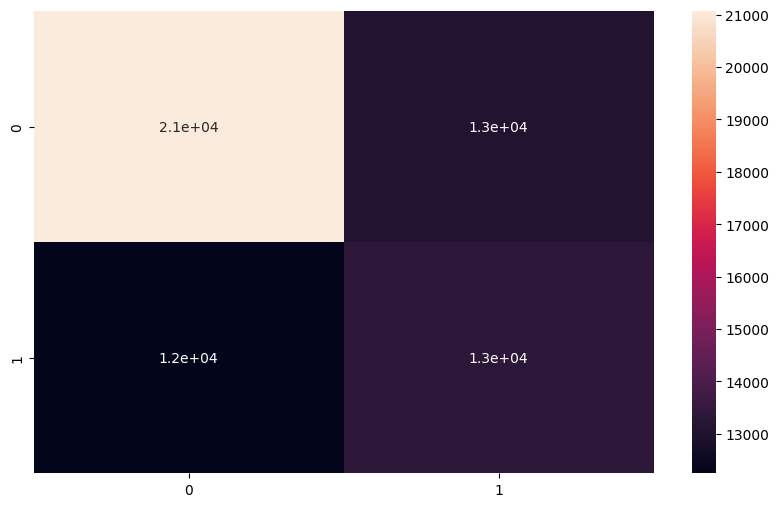

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(mt.y_test,binary_predictions_dense_mt),annot=True)

In [ ]:
# Choose a threshold
threshold = 0.5

predictions_dense_mt2 = mt.model_dense.predict(mt2.X_test)

# Apply thresholding to convert probabilities to binary predictions
binary_predictions_dense_mt2 = (predictions_dense_mt2 > threshold).astype(int)

# Now you can use classification_report on binary predictions
print(classification_report(mt2.y_test, binary_predictions_dense_mt2))

1923/1923 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.51      0.97      0.67     27251
           1       0.92      0.25      0.39     34273

    accuracy                           0.57     61524
   macro avg       0.72      0.61      0.53     61524
weighted avg       0.74      0.57      0.51     61524



In [ ]:
confusion_matrix(mt2.y_test,binary_predictions_dense_mt2)

array([[26541,   710],
       [25781,  8492]])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 54, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 54, 512)           1052672   
                                                                 
 dropout_2 (Dropout)         (None, 54, 512)           0         
                                                                 
 conv1d (Conv1D)             (None, 31, 256)           3145984   
                                                                 
 dropout_3 (Dropout)         (None, 31, 256)           0         
                                                                 
 average_pooling1d (Average  (None, 15, 256)           0         
 Pooling1D)                                                      
                                                           

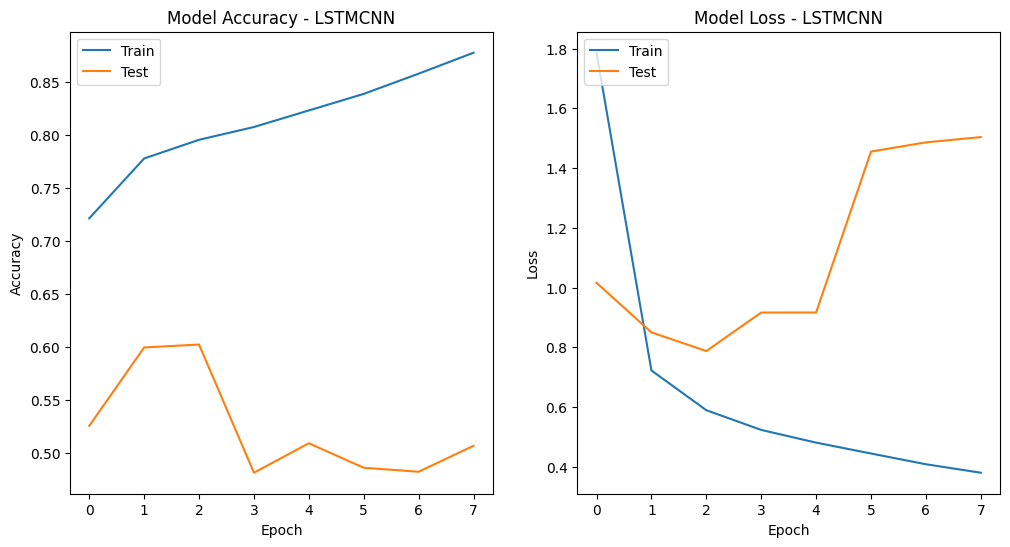

0.5071501731872559 1.5038423538208008


In [ ]:
# Train the LSTMCNN model and get its history
trainHistory, accuracy, loss = mt.LSTMCNN_model()
#
# # Plot the training history
plot_training_history(trainHistory, "LSTMCNN")

print(accuracy, loss)

In [ ]:
losses = pd.DataFrame(mt.model_lstmcnn.history.history)
losses.head()

,loss,accuracy,precision_1,recall_1,val_loss,val_accuracy,val_precision_1,val_recall_1,lr
0,1.786412,0.721711,0.736500,0.796106,1.015949,0.525927,0.472612,0.923854,0.001
1,0.722403,0.778192,0.789891,0.831701,0.849932,0.599893,0.531719,0.550288,0.001
2,0.589282,0.795824,0.805517,0.845594,0.787385,0.602659,0.535728,0.540657,0.001
3,0.523278,0.807895,0.811495,0.863133,0.916392,0.481718,0.445768,0.864346,0.001
4,0.480724,0.823515,0.825417,0.875170,0.916526,0.509497,0.450221,0.657714,0.001


<Axes: >

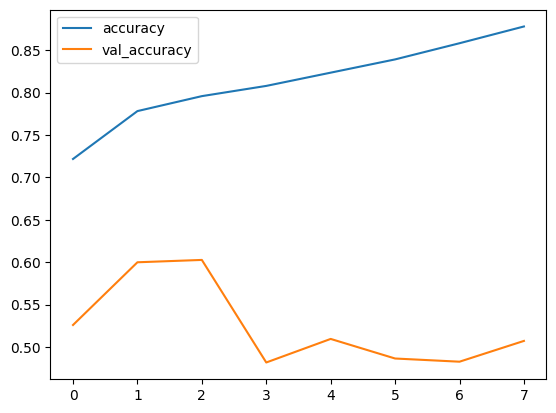

In [ ]:
losses[['accuracy','val_accuracy']].plot()

In [ ]:
mt.model_lstmcnn.metrics_names

['loss', 'accuracy', 'precision_1', 'recall_1']

In [ ]:
print(mt.model_lstmcnn.metrics_names)
print(mt.model_lstmcnn.evaluate(np.expand_dims(mt.X_test, axis=-1),mt.y_test,verbose=0))

['loss', 'accuracy', 'precision_1', 'recall_1']
[0.7873842716217041, 0.6026588678359985, 0.5357281565666199, 0.5406569242477417]


In [ ]:
predictions = mt.model_lstmcnn.predict(np.expand_dims(mt.X_test, axis=-1))

1865/1865 [==============================] - 11s 5ms/step


In [ ]:
# Choose a threshold
threshold = 0.5

# Apply thresholding to convert probabilities to binary predictions
binary_predictions = (predictions > threshold).astype(int)

# Now you can use classification_report on binary predictions
print(classification_report(mt.y_test, binary_predictions))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65     34106
           1       0.54      0.54      0.54     25543

    accuracy                           0.60     59649
   macro avg       0.59      0.59      0.59     59649
weighted avg       0.60      0.60      0.60     59649



In [ ]:
confusion_matrix(mt.y_test,binary_predictions)

array([[22138, 11968],
       [11733, 13810]])

<Axes: >

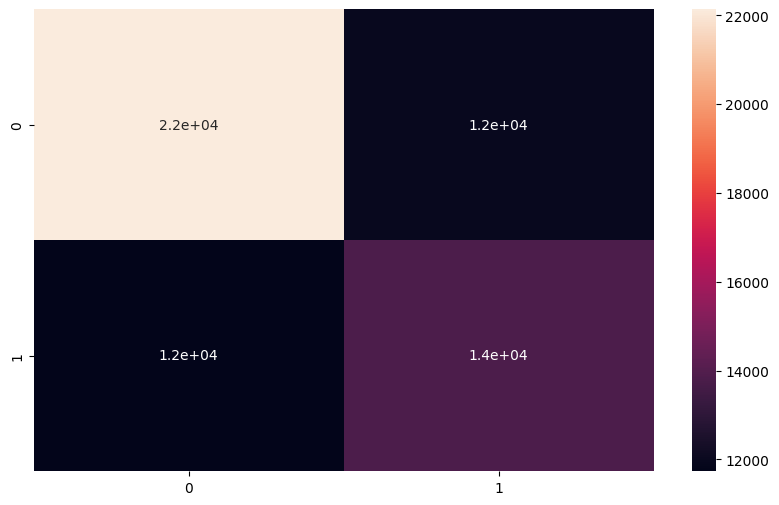

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(mt.y_test,binary_predictions),annot=True)

In [ ]:
# Choose a threshold
threshold = 0.5

# Apply model to the second dataframe to predict
predictions_lstmcnn_mt2 = mt.model_lstmcnn.predict(np.expand_dims(mt2.X_test, axis=-1))

# Apply thresholding to convert probabilities to binary predictions
binary_predictions_lstmcnn_mt2 = (predictions_lstmcnn_mt2 > threshold).astype(int)

# Now you can use classification_report on binary predictions
print(classification_report(mt2.y_test, binary_predictions_lstmcnn_mt2))

1923/1923 [==============================] - 11s 6ms/step
              precision    recall  f1-score   support

           0       0.49      0.97      0.65     27251
           1       0.91      0.19      0.32     34273

    accuracy                           0.54     61524
   macro avg       0.70      0.58      0.48     61524
weighted avg       0.72      0.54      0.47     61524



In [ ]:
confusion_matrix(mt2.y_test,binary_predictions_lstmcnn_mt2)

array([[26564,   687],
       [27690,  6583]])

In [ ]:
mt.merged_df.columns

Index(['bidSize_1', 'bidPrice_1', 'askPrice_1', 'askSize_1', 'bidSize_2',
       'bidPrice_2', 'askPrice_2', 'askSize_2', 'bidSize_3', 'bidPrice_3',
       'askPrice_3', 'askSize_3', 'bidSize_4', 'bidPrice_4', 'askPrice_4',
       'askSize_4', 'bidSize_5', 'bidPrice_5', 'askPrice_5', 'askSize_5',
       'bidSize_6', 'bidPrice_6', 'askPrice_6', 'askSize_6', 'bidSize_7',
       'bidPrice_7', 'askPrice_7', 'askSize_7', 'bidSize_8', 'bidPrice_8',
       'askPrice_8', 'askSize_8', 'bidSize_9', 'bidPrice_9', 'askPrice_9',
       'askSize_9', 'bidSize_10', 'bidPrice_10', 'askPrice_10', 'askSize_10',
       'lastPrice', 'lastSize', 'time', 'mid_price', 'spread',
       'book_imbalance', 'bid_vwap_distance', 'ask_vwap_distance',
       'bidSize_trend_1', 'askSize_trend_1', 'historical_volatility',
       'time_of_day', 'day_of_week', 'mid_price_movement',
       'order_flow_momentum', 'direction'],
      dtype='object')